In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import os
import sys
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns


#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize, Evaluate
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet, get_unet_mod
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from imports.models.losses import bce_dice_loss, dice_coeff, iou
from keras.models import load_model, model_from_json
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score

import keras.losses
keras.losses.custom_loss = bce_dice_loss

model = load_model('../saved_models/unet/vgg19_80_20/unet_vgg19_80_20.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff,'iou':iou,"bce_jaccard_loss":bce_jaccard_loss})

In [37]:
layers = [layer for layer in model.layers]
layers

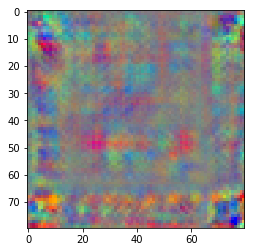

In [49]:
def deprocess_image(img):
    img -= img.mean()
    img /= (img.std()+1e-5)
    img *= 0.1
    
    img += 0.5
    img = np.clip(img,0,1)
    
    img *= 255
    img = np.clip(img,0,255).astype("uint8")
    return img

def generate_pattern(layer_name,filter_index,size=(80,80)):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss,model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads)))+1e-5)
    iterate = K.function([model.input],[loss,grads])
    loss_value, grads_value = iterate([np.zeros((1,*size,3))])

    input_img_data = np.random.random((1,*size,3))*20.+128.
    step = 1.
    for i in range(50):
        loss_value, grads_value = iterate([np.zeros((1,*size,3))])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

imshow(generate_pattern("conv2d_57",2))

In [7]:
shape = (512,768)

from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

im = imread(DATA_BASE_PATH+'/00_all/images/img_1000.png')
im = resize(im,shape)
 
def get_intermediate_layer(n_layer,input_shape=(512,768)):
    new_model = Model(input=[model.layers[0].input], output=[model.layers[n_layer].output])
    activations = new_model.predict(im.reshape(1,input_shape[0],input_shape[1],3))
    shape = (activations.shape[1],activations.shape[2])
    n_kernels = activations.shape[3]
    print("Number of Kernels: " + str(n_kernels))
    n_filters = activations.shape[3]
    fig, axs = plt.subplots(ncols=4,nrows=math.ceil(n_kernels/4),figsize=(20,(n_layer//4)*5))
    k = 0
    for i in range(math.ceil(n_kernels/4)):
        for j in range(4):
            axs[i,j].imshow(activations[0,:,:,k].reshape(shape),cmap="YlGn")
            axs[i,j].axis('off')
            axs[i,j].set_title(f"Outputlayer: {n_layer}, Kernel: {k}")
            k += 1
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

Number of Kernels: 128


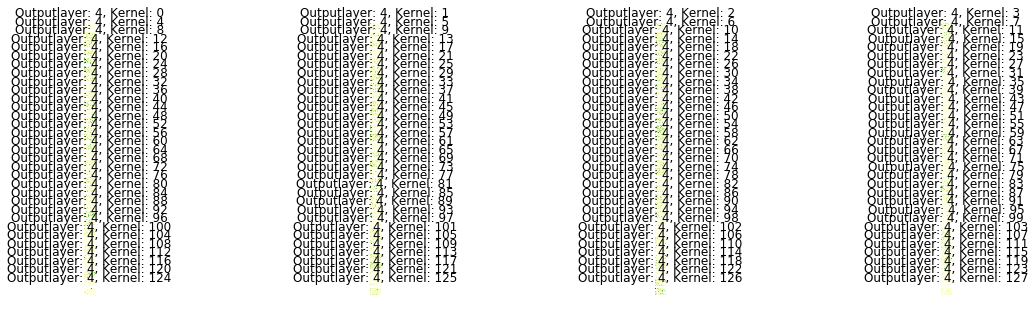

In [11]:
get_intermediate_layer(4)

In [42]:
import math

shape = (512,768)

from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

im = imread(DATA_BASE_PATH+'/00_all/images/img_1000.png')
im = resize(im,shape)
 
def get_intermediate_layer(n_layer,input_shape=(512,768)):
    new_model = Model(input=[model.layers[0].input], output=[model.layers[n_layer].output])
    n_kernels = model.layers[n_layer].output_shape[3]
    n_x = int(math.sqrt(n_kernels))
    n_y = n_kernels // n_x
    activations = new_model.predict(im.reshape(1,*input_shape,3))
    
    shape = (activations.shape[1],activations.shape[2])
    
    print("Number of Kernels: " + str(n_kernels))
    
    fig, axs = plt.subplots(ncols=n_x,nrows=n_y,figsize=(20,(n_layer//4)*5))
    k = 0
    for i in range(math.ceil(n_kernels/4)):
        for j in range(4):
            axs[i,j].imshow(activations[0,:,:,k].reshape(shape),cmap="YlGn")
            axs[i,j].axis('off')
            axs[i,j].set_title(f"Outputlayer: {n_layer}, Kernel: {k}")
            k += 1
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

In [43]:
get_intermediate_layer(2)

8
8
(1, 512, 768, 64)
Number of Kernels: 64
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fc1c7bd8510> (for post_execute):


ValueError: 'box_aspect' and 'fig_aspect' must be positive

ValueError: 'box_aspect' and 'fig_aspect' must be positive

<Figure size 1440x0 with 64 Axes>

Number of Kernels: 64


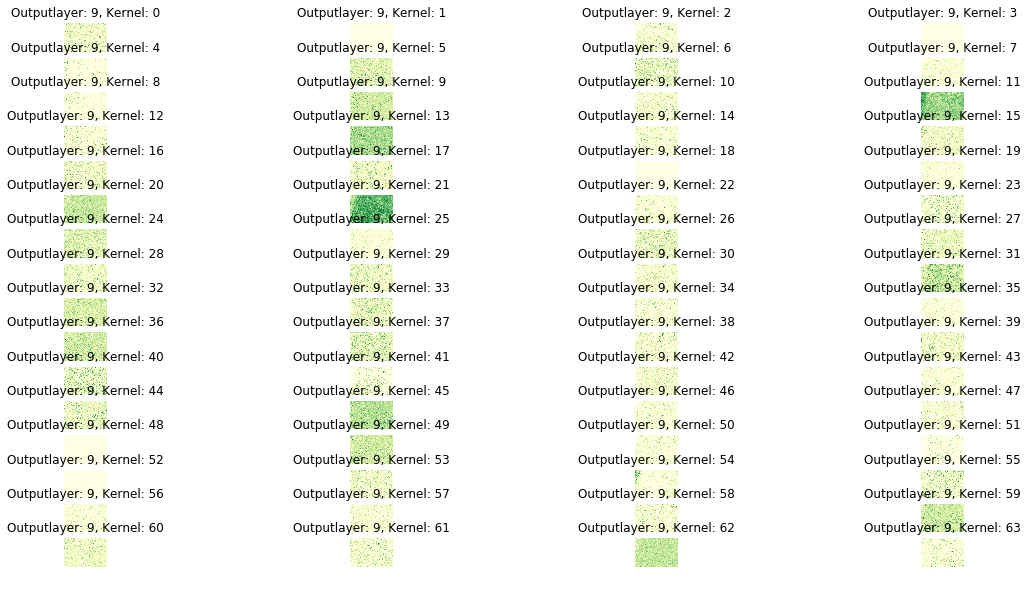

In [12]:
get_intermediate_layer(9)

Number of Kernels: 16


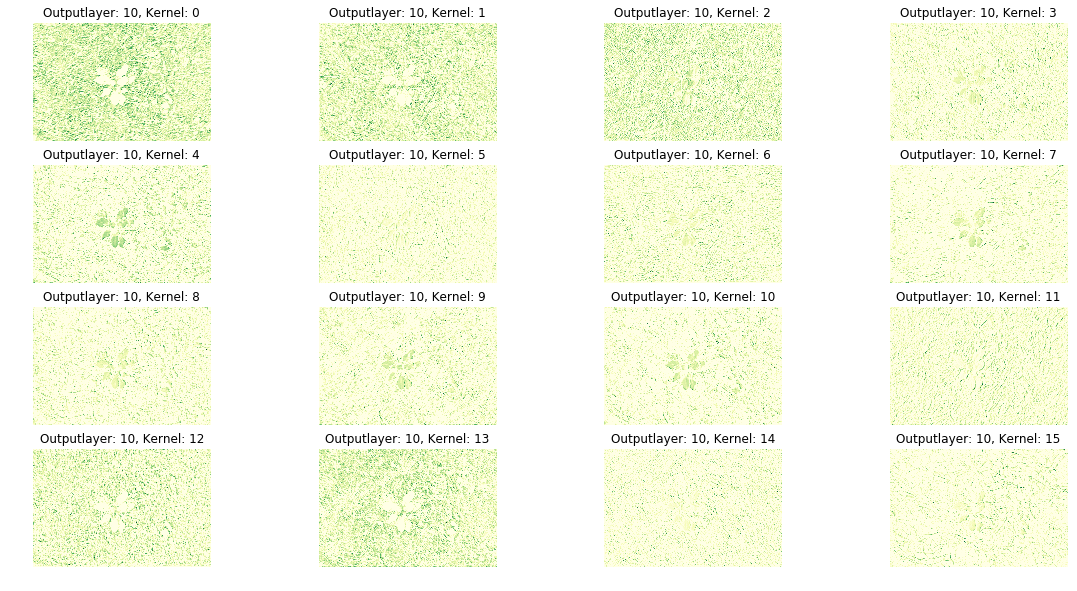

In [63]:
get_intermediate_layer(10)

16


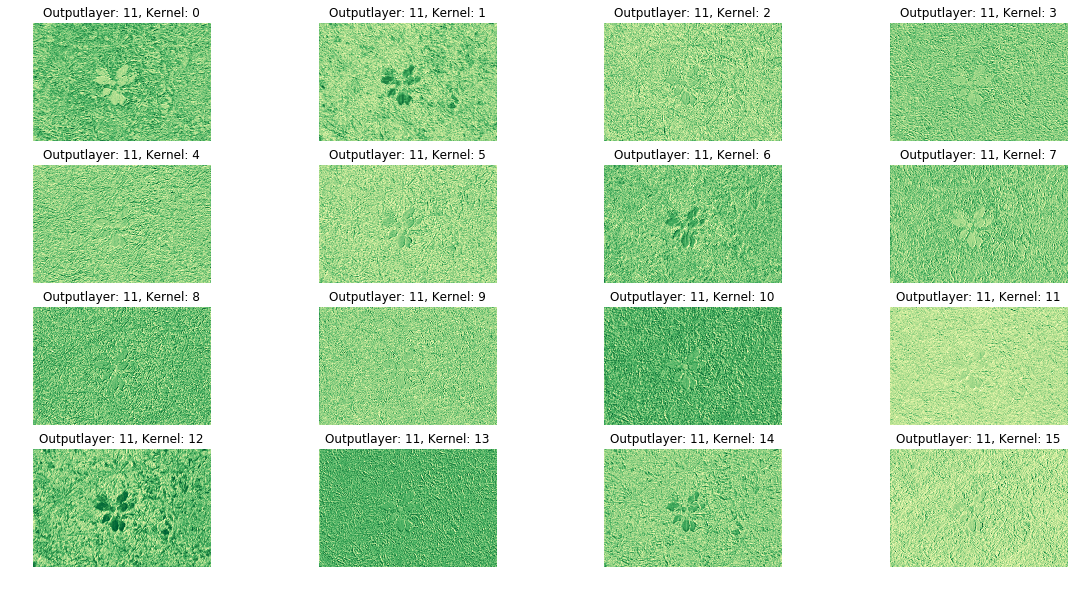

In [60]:
get_intermediate_layer(11)

512


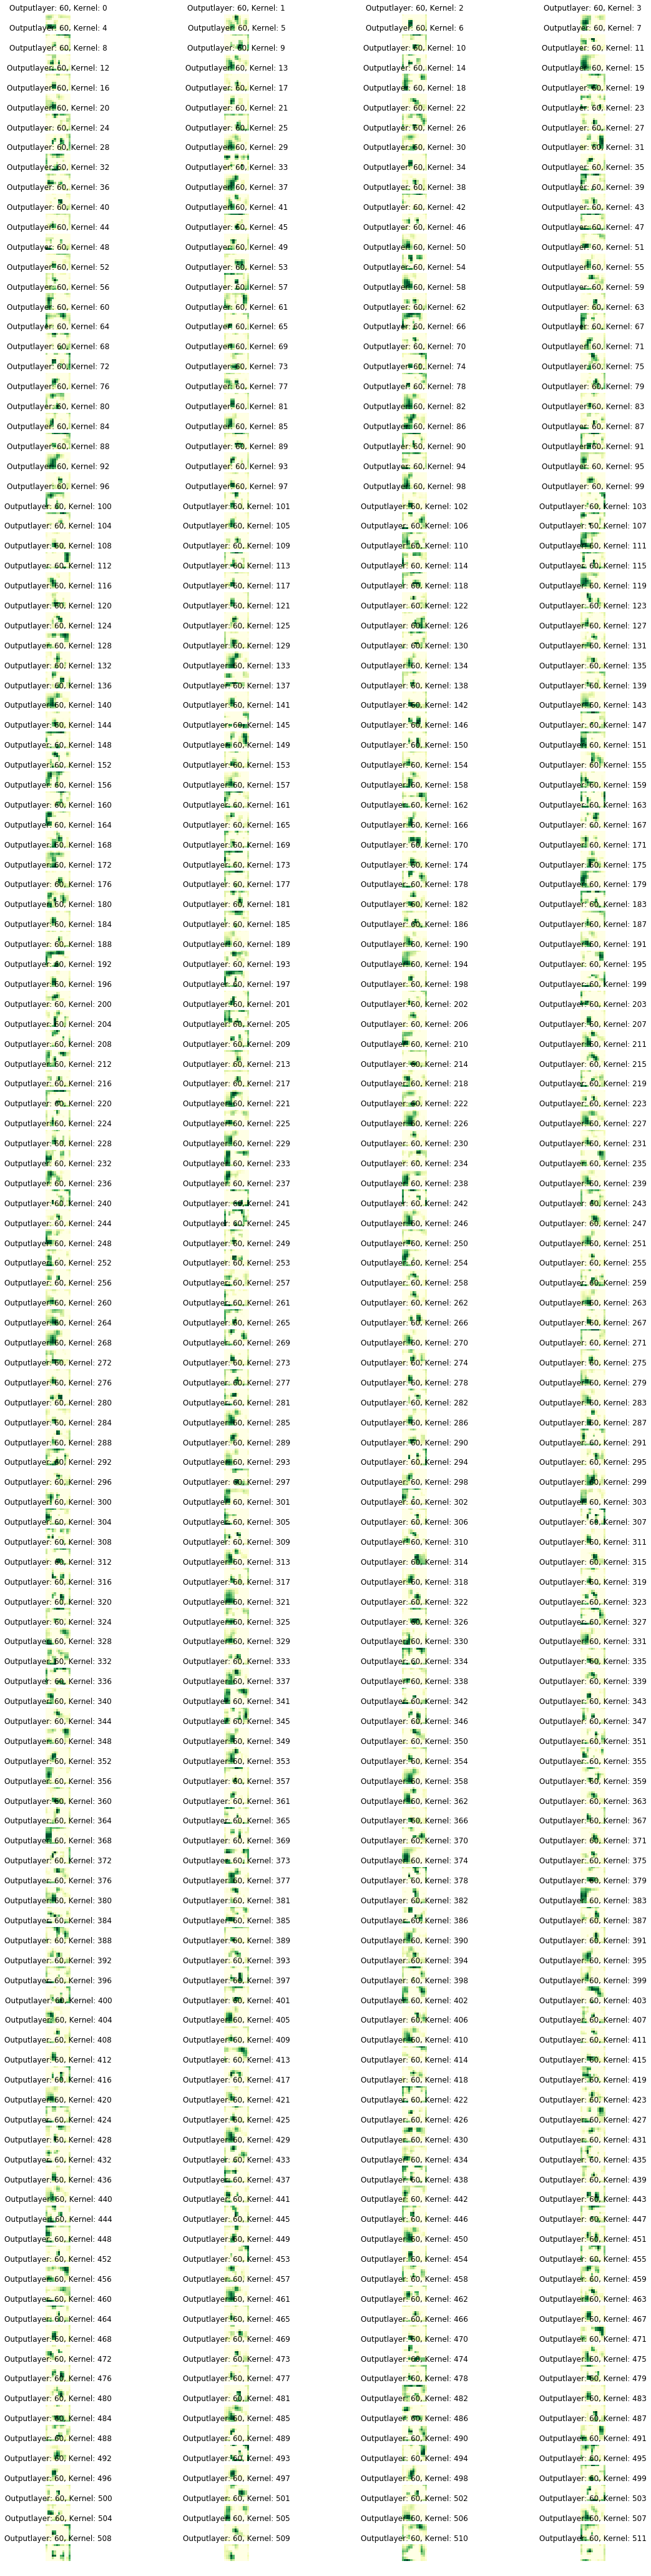

In [61]:
get_intermediate_layer(60)